In [33]:
print("strawberry")

strawberry


In [34]:
import torch
import numpy as np

# dataset
from twaidata.torchdatasets.in_ram_ds import MRISegmentation2DDataset, MRISegmentation3DDataset
from torch.utils.data import DataLoader, random_split, ConcatDataset

# model
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import HyperMapp3r
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_DDU import HyperMapp3rDDU
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_SSN import HyperMapp3rSSN


# augmentation and pretrain processing
from trustworthai.utils.augmentation.standard_transforms import RandomFlip, GaussianBlur, GaussianNoise, \
                                                            RandomResizeCrop, RandomAffine, \
                                                            NormalizeImg, PairedCompose, LabelSelect, \
                                                            PairedCentreCrop, CropZDim
# loss function
from trustworthai.utils.losses_and_metrics.per_individual_losses import (
    dice_loss,
    log_cosh_dice_loss,
    TverskyLoss,
    FocalTverskyLoss,
    DiceLossMetric
)
from torch.nn import BCELoss, MSELoss, BCEWithLogitsLoss

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
import pytorch_lightning as pl

# misc
import os
import torch
import matplotlib.pyplot as plt
import torch
from torchinfo import summary

### Set the seed

In [35]:
seed = 3407
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

### define datasets and dataloaders

In [36]:
is3D = False

In [37]:
root_dir = "/disk/scratch/s2208943/ipdis/preprep/out_data/collated/"
#root_dir = "/media/benp/NVMEspare/datasets/preprocessing_attempts/local_results/collated/"
wmh_dir = root_dir + "WMH_challenge_dataset/"
ed_dir = root_dir + "EdData/"

In [38]:
# domains = [
#             wmh_dir + d for d in ["Singapore", "Utrecht", "GE3T"]
#           ]

# domains = [
#             wmh_dir + d for d in ["Singapore", "Utrecht", "GE3T"]
#           ] + [
#             ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]
#           ]


domains = [
            ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]
          ]

In [39]:
# augmentation definintion
def get_transforms(is_3D):
    transforms = [
        LabelSelect(label_id=1),
        RandomFlip(p=0.5, orientation="horizontal"),
        # GaussianBlur(p=0.5, kernel_size=7, sigma=(.1, 1.5)),
        # GaussianNoise(p=0.2, mean=0, sigma=0.2),
        # RandomAffine(p=0.2, shear=(.1,3.)),
        # RandomAffine(p=0.2, degrees=5),
        #RandomResizeCrop(p=1., scale=(0.6, 1.), ratio=(3./4., 4./3.))
        
        
        RandomResizeCrop(p=1., scale=(0.3, 0.5), ratio=(3./4., 4./3.)) # ssn
    ]
    if not is_3D:
        transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
        return PairedCompose(transforms)
    else:
        transforms.append(CropZDim(size=32, minimum=0, maximum=-1))
        transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
        return PairedCompose(transforms)

In [40]:
# function to do train validate test split
test_proportion = 0.1
validation_proportion = 0.2

def train_val_test_split(dataset, val_prop, test_prop, seed):
    # I think the sklearn version might be prefereable for determinism and things
    # but that involves fiddling with the dataset implementation I think....
    size = len(dataset)
    test_size = int(test_prop*size) 
    val_size = int(val_prop*size)
    train_size = size - val_size - test_size
    train, val, test = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(seed))
    return train, val, test

In [41]:
# load datasets
# this step is quite slow, all the data is being loaded into memory
if is3D:
    datasets_domains = [MRISegmentation3DDataset(root_dir, domain, transforms=get_transforms(is_3D=True)) for domain in domains]
else:
    datasets_domains = [MRISegmentation2DDataset(root_dir, domain, transforms=get_transforms(is_3D=False)) for domain in domains]

# split into train, val test datasets
datasets = [train_val_test_split(dataset, validation_proportion, test_proportion, seed) for dataset in datasets_domains]

# concat the train val test datsets
train_dataset = ConcatDataset([ds[0] for ds in datasets])
val_dataset = ConcatDataset([ds[1] for ds in datasets])
test_dataset = ConcatDataset([ds[2] for ds in datasets])

In [42]:
len(train_dataset), len(val_dataset), len(test_dataset)

(8743, 2497, 1248)

In [43]:
# define dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

In [12]:
import torch
import torch.nn as nn
from trustworthai.models.uq_models.drop_UNet import normalization_layer
import torch.nn.functional as F
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import HyperMapp3r
import torch.distributions as td
from typing import Tuple


def get_conv_func(dims, transpose=False):
    # determine convolution func
        if dims == 2:
            if transpose:
                return nn.ConvTranspose2d
            else:
                return nn.Conv2d
        elif dims == 3:
            if transpose:
                return nn.ConvTranspose3d
            else:
                return nn.Conv3d
        else:
            raise ValueError(f"values of dims of 2 or 3 (2D or 2D conv) are supported only, not {dims}")
            
def get_dropout_func(dims):
    if dims == 2:
        return nn.Dropout2d
    if dims == 3:
        return nn.Dropout3d
    else:
        return nn.Dropout

class ReshapedDistribution(td.Distribution):
    def __init__(self, base_distribution: td.Distribution, new_event_shape: Tuple[int, ...]):
        super().__init__(batch_shape=base_distribution.batch_shape, event_shape=new_event_shape, validate_args=False)
        self.base_distribution = base_distribution
        self.new_shape = base_distribution.batch_shape + new_event_shape
        
        #print("base distribution: ", self.base_distribution)

    @property
    def support(self):
        return self.base_distribution.support

    @property
    def arg_constraints(self):
        return self.base_distribution.arg_constraints()

    @property
    def mean(self):
        return self.base_distribution.mean.view(self.new_shape)

    @property
    def variance(self):
        return self.base_distribution.variance.view(self.new_shape)

    def rsample(self, sample_shape=torch.Size()):
        return self.base_distribution.rsample(sample_shape).view(sample_shape + self.new_shape)

    def log_prob(self, value):
        return self.base_distribution.log_prob(value.view(self.batch_shape + (-1,)))

    def entropy(self):
        return self.base_distribution.entropy()    
    
class HyperMapp3rSSN2(HyperMapp3r):
    def __init__(self, dims=3,
                 in_channels=3,
                 out_channels=1,
                 encoder_features=[16, 32, 64, 128, 256],
                 decoder_features=[128, 64, 32, 16],
                 softmax=True,
                 up_res_blocks=False,
                 block_params={
                     "dropout_p":0.1,
                     "norm_type":"in", 
                     "dropout_both_layers":False,
                 },
                 ssn_rank = 10,
                 ssn_epsilon=1e-5,
                 ssn_diagonal=False
                ):
        super().__init__(dims=dims,
                 in_channels=in_channels,
                 out_channels=decoder_features[-1], # last layer of just keeps number of nodes fixed this time
                 encoder_features=encoder_features,
                 decoder_features=decoder_features,
                 softmax=False,
                 up_res_blocks=up_res_blocks,
                 block_params=block_params)
        
        print("WARNING: this model assumes that the input to the model contains the brain mask in the first channel!")
        conv_func = get_conv_func(dims, transpose=False)
        self.ssn_rank = ssn_rank
        self.ssn_diagonal = ssn_diagonal
        self.ssn_epsilon = ssn_epsilon
        self.ssn_num_classes = out_channels
        
        self.lrelu = nn.LeakyReLU(0.01)
        
        self.mean_l = conv_func(decoder_features[-1], out_channels, kernel_size = (1,) *  dims, padding='same')
        self.log_cov_diag_l = conv_func(decoder_features[-1], out_channels, kernel_size = (1,) * dims, padding='same')
        self.cov_factor_l = conv_func(decoder_features[-1], out_channels * ssn_rank, kernel_size = (1,) * dims, padding='same')

    def forward(self, x):
        logits = self.lrelu(super().forward(x))
        if torch.sum(torch.isnan(logits)) > 0:
            print("NAN 1", torch.sum(torch.isnan(logits)))
        batch_size = logits.shape[0]
        event_shape = (self.ssn_num_classes,) + logits.shape[2:]
        
        mean = self.mean_l(logits)
        mean = mean.view((batch_size, -1))
        
        cov_diag = self.log_cov_diag_l(logits).exp() + self.ssn_epsilon
        cov_diag = cov_diag.view((batch_size, -1))
        
        cov_factor = self.cov_factor_l(logits)
        cov_factor = cov_factor.view((batch_size, self.ssn_rank, self.ssn_num_classes, -1))
        cov_factor = cov_factor.flatten(2,3)
        cov_factor = cov_factor.transpose(1,2)
        if torch.sum(torch.isnan(mean)) > 0:
            print("NAN 2")
        if torch.sum(torch.isnan(cov_diag)) > 0:
            print("NAN 3")
        if torch.sum(torch.isnan(cov_factor)) > 0:
            print("NAN 4")
        
        # covariance tends to blow up to infinity, hence set to 0 outside the ROI
        mask = x[:,1]
        mask = mask.unsqueeze(1).expand((batch_size, self.ssn_num_classes) + mask.shape[1:]).reshape(batch_size, -1)
        cov_factor = cov_factor * mask.unsqueeze(-1)
        cov_diag = cov_diag * mask + self.ssn_epsilon
        
        if torch.sum(torch.isnan(mask)) > 0:
            print("NAN 5")
        if torch.sum(torch.isnan(cov_factor)) > 0:
            print("NAN 6")
        if torch.sum(torch.isnan(cov_diag)) > 0:
            print("NAN 7")
        
        if self.ssn_diagonal:
            base_distribution = td.Independent(td.Normal(loc=mean, scale=torch.sqrt(cov_diag)), 1)
        else:
            try:
                base_distribution = td.LowRankMultivariateNormal(loc=mean, cov_factor=cov_factor, cov_diag=cov_diag)
                #print("using multivariate normal!")
            except Exception as e:
                print("was thrown: ", e)
                print('hmm: Covariance became non invertible using independent normals for this batch!')
                print("cov diag okay: ", torch.sum(cov_diag <=0))
                print("sqrt cov diag okay: ", torch.sum(torch.sqrt(cov_diag) <=0))
                
                try:
                    base_distribution = td.Independent(td.Normal(loc=mean, scale=torch.sqrt(cov_diag)),1)
                except Exception as e:
                    print("second fail: ", e)
                    print(torch.min(torch.sqrt(cov_diag), torch.max(torch.sqrt(cov_diag))))
        
        distribution = ReshapedDistribution(base_distribution, event_shape)
        
        shape = (batch_size,) + event_shape
        logit_mean_view = mean.view(shape).detach()
        cov_diag_view = cov_diag.view(shape).detach()
        cov_factor_view = cov_factor.transpose(2,1).view((batch_size, self.ssn_num_classes * self.ssn_rank) + event_shape[1:]).detach()
        
        
        output_dict = {
            'logit_mean':logit_mean_view,
            'cov_diag':cov_diag_view,
            'cov_factor':cov_factor_view,
            'distribution':distribution,
        }
        
        return output_dict

### setup model

In [13]:
in_channels = 3
out_channels = 1

if is3D:
    pass
else:
    # encoder_features=[16, 32, 64, 128, 256] # orig: [16, 32, 64, 128, 256]
    # decoder_features=encoder_features[::-1][1:]
#     model = HyperMapp3r(dims=2,
#                  in_channels=3,
#                  out_channels=2,
#                  encoder_features=[16, 32, 64, 128, 256],
#                  decoder_features=[128, 64, 32, 16],
#                  softmax=False,
#                  up_res_blocks=False,
#                  block_params={
#                      "dropout_p":0.1,
#                      "norm_type":"in", 
#                      "dropout_both_layers":False,
#                  }
#                    )
    
    # model = HyperMapp3rDDU(dims=2,
    #              in_channels=3,
    #              out_channels=2,
    #              encoder_features=[16, 32, 64, 128, 256],
    #              decoder_features=[128, 64, 32, 16],
    #              softmax=False,
    #              up_res_blocks=True,
    #              n_power_iterations=3, 
    #              eps=1e-12,
    #              block_params={
    #                  "dropout_p":0.1,
    #                  "norm_type":"in", 
    #                  "dropout_both_layers":False,
    #              }
    #                )
    
    model_raw = HyperMapp3rSSN2(dims=2,
                 in_channels=3,
                 out_channels=2,
                 encoder_features=[16, 32, 64, 128, 256],
                 decoder_features=[128, 64, 32, 16],
                 softmax=True,
                 up_res_blocks=False,
                 block_params={
                     "dropout_p":0.1,
                     "norm_type":"in", 
                     "dropout_both_layers":False,
                 },
                 ssn_rank = 10,
                 ssn_epsilon=1e-5,
                 ssn_diagonal=False)
    
    #optimizer_params={"lr":2e-3}
    #lr_scheduler_params={"step_size":20, "gamma":0.1}
    # optimizer_params={"lr":2e-3, "momentum":0.6}
    # optimizer = torch.optim.RMSprop
    # lr_scheduler_params={"milestones":[10,100,200], "gamma":0.5}
    # lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR


In [14]:
#summary(model_raw)

In [15]:
#model.load_state_dict(torch.load("ssn_trained_no_wrapper_class.ckpt"))

In [16]:
import pytorch_lightning as pl

import torch
import torch.nn as nn
import torch.nn.functional as F

class StandardLitModelWrapper(pl.LightningModule):
    def __init__(self, model, loss=F.cross_entropy, logging_metric=None, optimizer_params={"lr":1e-3}, lr_scheduler_params={"step_size":30, "gamma":0.1}, is_uq_model=False,
                optimizer_constructor=None, lr_scheduler_constructor=None):
        super().__init__()
        self.model = model
        self.loss = loss
        self.logging_metric_train = logging_metric()
        self.logging_metric_val = logging_metric()
        self.optim_params = optimizer_params
        self.lr_scheduler_params = lr_scheduler_params
        self.is_uq_model = False
        self.optimizer_constructor = optimizer_constructor
        self.lr_scheduler_constructor = lr_scheduler_constructor

        
    def forward(self, x, **kwargs):
        return self.model(x, **kwargs)
    
    def configure_optimizers(self):
        # optimizer and schedulers go in the configure optimizers hook
        if self.optimizer_constructor:
            optimizer = self.optimizer_constructor(self.parameters(), **self.optim_params)
        else:
            optimizer = torch.optim.Adam(self.parameters(), **self.optim_params)
        
        if self.lr_scheduler_constructor:
            lr_scheduler = self.lr_scheduler_constructor(optimizer, **self.lr_scheduler_params)
        else:
            lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, **self.lr_scheduler_params)
        
        return [optimizer], [lr_scheduler]
    
    def training_step(self, batch, batch_idx):
        """
        lightning automates the training loop, 
        does epoch, back_tracking, optimizers and schedulers,
        and metric reduction.
        we just define how we want to process a single batch. 
        we can optionally pass optimizer_idx if we want to define multiple optimizers within the configure_optimizers
        hook, and I presume we can add our own parameters also to functions?
        """
        
        if self.is_uq_model:
            self.model.set_applyfunc(True)
        
        X, y = batch
        y_hat = self(X)
        loss = self.loss(y_hat, y)
        
        # metrics 
        if self.logging_metric_train:
            self.logging_metric_train(y_hat, y)
            self.log(f"train_metric", self.logging_metric_train, on_step=True, on_epoch=False, prog_bar=True)
        self.log("train_loss", loss)
        
        return loss
    
#     def training_epoch_end(self, outs):
#         self.log('train_metric_epoch', self.logging_metric_train.compute())
        
#     def validation_epoch_end(self, outs):
#         self.log('val_metric_epoch', self.logging_metric_val.compute())
    
    def validation_step(self, batch, batch_idx):
        """
        note: call trainer.validate() automatically loads the best checkpoint if checkpointing was enabled during fitting
        well yes I want to enable checkpointing but will deal with that later.
        also it does stuff like model.eval() and torch.no_grad() automatically which is nice.
        I will need a custom eval thing to do my dropout estimation but can solve that later too.
        """
        if self.is_uq_model:
            self.model.set_applyfunc(False)
        
        X, y = batch
        y_hat = self(X)
        val_loss = self.loss(y_hat, y)
        
        if self.logging_metric_val:
            self.logging_metric_val(y_hat, y)
            self.log(f"val_metric", self.logging_metric_val, on_step=True, on_epoch=True, prog_bar=True)
        self.log("val_loss", val_loss)
        
    def test_step(self, batch, batch_idx):
        """
        we would need to directly call this function using the trainer
        """
        
        if self.is_uq_model:
            self.model.set_applyfunc(False)
        
        X, y = batch
        y_hat = self(X)
        test_loss = self.loss(y_hat, y)
        self.log("test_loss", test_loss)
        
    def predict_step(self, batch, batch_idx):
        """
        just for making predictions as opposed to collecting metrics etc
        note to use this, we just call .predict(dataloader) and it then automates the look
        these functions are for a single batch. Nice.
        """
        X, y = batch
        pred = self(X)
        return pred

In [17]:
#loss = dice_loss
#loss = torch.nn.CrossEntropyLoss(weight=torch.Tensor([0.968, 0.032]))
#loss = FocalLoss(gamma=1., reduction='mean', alpha=torch.Tensor([1-0.968, 1-0.032]))
#loss = log_cosh_dice_loss
#loss = TverskyLoss(beta=0.7)
#loss = FocalTverskyLoss(beta=0.7, gamma=0.8)

In [18]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import math


class StochasticSegmentationNetworkLossMCIntegral(nn.Module):
    def __init__(self, num_mc_samples: int = 1):
        super().__init__()
        self.num_mc_samples = num_mc_samples

    @staticmethod
    def fixed_re_parametrization_trick(dist, num_samples):
        assert num_samples % 2 == 0
        samples = dist.rsample((num_samples // 2,))
        mean = dist.mean.unsqueeze(0)
        samples = samples - mean
        return torch.cat([samples, -samples]) + mean

    def forward(self, result_dict, target, **kwargs):
        logits = result_dict['logit_mean']
        distribution = result_dict['distribution']
        
        batch_size = logits.shape[0]
        num_classes = logits.shape[1]
        assert num_classes >= 2  # not implemented for binary case with implied background
        # logit_sample = distribution.rsample((self.num_mc_samples,))
        logit_sample = self.fixed_re_parametrization_trick(distribution, self.num_mc_samples)
        target = target.unsqueeze(1)
        target = target.expand((self.num_mc_samples,) + target.shape)

        flat_size = self.num_mc_samples * batch_size
        logit_sample = logit_sample.view((flat_size, num_classes, -1))
        target = target.reshape((flat_size, -1))

        log_prob = -F.cross_entropy(logit_sample, target, reduction='none').view((self.num_mc_samples, batch_size, -1))
        loglikelihood = torch.mean(torch.logsumexp(torch.sum(log_prob, dim=-1), dim=0) - math.log(self.num_mc_samples))
        loss = -loglikelihood
        return loss

In [19]:
def fixed_re_parametrization_trick(dist, num_samples):
        assert num_samples % 2 == 0
        samples = dist.rsample((num_samples // 2,))
        mean = dist.mean.unsqueeze(0)
        samples = samples - mean
        return torch.cat([samples, -samples]) + mean


class SsnNetworkMeanLossWrapper(nn.Module):
    def __init__(self, loss_func):
        super().__init__()
        self.loss = loss_func
    def forward(self, result_dict, target):
        mean = result_dict['logit_mean']
        return self.loss(mean, target)
    
class SsnNetworkSampleLossWrapper(nn.Module):
    def __init__(self, loss_func, samples=10):
        super().__init__()
        self.loss = loss_func
        self.samples = samples
    def forward(self, result_dict, target):
        samples = fixed_re_parametrization_trick(result_dict['distribution'], self.samples).to(target.device)
        loss = 0
        for s in samples:
            loss += self.loss(s, target)
        return loss / self.samples
        #return torch.mean(torch.Tensor(losses))

In [20]:
class SsnDiceMetricWrapper(DiceLossMetric):

    def update(self, preds_dict, target: torch.Tensor):
        super().update(preds_dict['logit_mean'], target)

    def compute(self):
        return super().compute()

In [21]:
ssn_diceloss = SsnNetworkSampleLossWrapper(dice_loss)# SsnNetworkMeanLossWrapper(dice_loss)
mc_loss = StochasticSegmentationNetworkLossMCIntegral(num_mc_samples=10)

def double_loss(outs, target):
    return ssn_diceloss(outs, target) * 10 + mc_loss(outs, target) * 0.01

In [22]:
# loss = StochasticSegmentationNetworkLossMCIntegral(num_mc_samples=10)
# loss = SsnNetworkSampleLossWrapper(dice_loss)
loss = double_loss

In [23]:
#optimizer_params={"lr":2e-4, "momentum":0.6}
optimizer_params={"lr":1e-3}
optimizer = torch.optim.Adam
lr_scheduler_params={"milestones":[100,200], "gamma":0.5}
lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR

In [24]:
# model = StandardLitModelWrapper(model_raw, loss, 
#                                 logging_metric=SsnDiceMetricWrapper,
#                                 optimizer_params=optimizer_params,
#                                 lr_scheduler_params=lr_scheduler_params,
#                                 is_uq_model=False,
#                                 optimizer_constructor=optimizer,
#                                 lr_scheduler_constructor=lr_scheduler_constructor
#                                )


checkpoint= "ed_domains_ssn_trained.ckpt"
model = StandardLitModelWrapper.load_from_checkpoint(checkpoint, model=model_raw, loss=double_loss, logging_metric=SsnDiceMetricWrapper)

In [25]:
checkpoint_dir = "./lightning_logs"
strategy = None
# strategy = "deepspeed_stage_2"
# strategy = "dp"
#strategy = "deepspeed_stage_2_offload"

accelerator="gpu"
devices=1
max_epochs=500
precision = 32

checkpoint_callback = ModelCheckpoint(checkpoint_dir, save_top_k=2, monitor="val_loss")
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=500, verbose="False", mode="min", check_finite=True)
trainer = pl.Trainer(
    callbacks=[checkpoint_callback, early_stop_callback],
    accelerator=accelerator,
    devices=devices,
    max_epochs=max_epochs,
    strategy=strategy,
    precision=precision,
    default_root_dir=checkpoint_dir
)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### train

In [26]:
#trainer.fit(model, train_dataloader, val_dataloader)

In [44]:
trainer.validate(model, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            5.5706305503845215
    val_metric_epoch        0.22587046027183533
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_metric_epoch': 0.22587046027183533, 'val_loss': 5.5706305503845215}]

In [28]:
def entropy_map_from_samples(samples):
    "samples is of shape samples, batch size, channels, image dims  [s, b, c *<dims>]"
    probs = torch.nn.functional.softmax(samples, dim=2)
    pic = torch.mean(probs, dim=0)
    ent_map = torch.sum(-pic * torch.log(pic+1e-30), dim=1)
    
    return ent_map

### Plots

In [46]:
with torch.no_grad():
    x1, y1 = next(iter(val_dataloader))
    y_hat = model(x1.to(model.device))

In [29]:
def actual_dice(y_hat, y_true):
    y_hat = torch.nn.functional.softmax(y_hat, dim=1).argmax(dim=1)
    # count how many times the ground truth and target have nothing in them
    s0 = y_hat.shape[0]
    y_hat = y_hat.view(s0, -1)
    y_true = y_true.view(s0, -1)
    # print(torch.sum(torch.sum(y_true, dim=1) == 0))
    # print(torch.sum(torch.sum(y_hat, dim=1) == 0))
    # print(torch.sum(torch.logical_and(torch.sum(y_hat, dim=1) == 0, torch.sum(y_true, dim=1) == 0)))
    ignores = torch.sum(torch.logical_and(torch.sum(y_hat, dim=1) == 0, torch.sum(y_true, dim=1) == 0))
    
    
    numerator = torch.sum(2 * y_true * y_hat, dim=1)
    # print(numerator)
    denominator = torch.sum(y_true + y_hat, dim=1)
    # print(denominator)
    
    return torch.sum((numerator) / (denominator + 1e-8)) / (s0-ignores) # s0

In [30]:
def slice_dice(y_hat, y_true):
    y_hat = torch.nn.functional.softmax(y_hat, dim=0).argmax(dim=0)
    
    if torch.sum(y_hat) == 0 and torch.sum(y_true) == 0:
        return "n/a"
    
    numerator = torch.sum(2 * y_hat * y_true)
    denominator = torch.sum(y_hat + y_true)
    return numerator / (denominator + 1e-8)

In [31]:
def dice(y_pred, y_true):
    y_pred = torch.nn.functional.softmax(y_pred, dim=1).argmax(dim=1)
    denominator = torch.sum(y_pred) + torch.sum(y_true)
    numerator = 2. * torch.sum(torch.logical_and(y_pred, y_true))
    return numerator / denominator

In [47]:
ssn_diceloss(y_hat, y1.to(y_hat['logit_mean'].device))

tensor(0.2896)

In [48]:
mc_loss(y_hat, y1.to(y_hat['logit_mean'].device))

tensor(379.9918)

In [49]:
samples = fixed_re_parametrization_trick(y_hat['distribution'], 20)
probs = torch.nn.functional.softmax(samples, dim=2)
pic = torch.mean(probs, dim=0)
ent_map = torch.sum(-pic * torch.log(pic+1e-30), dim=1).cpu()

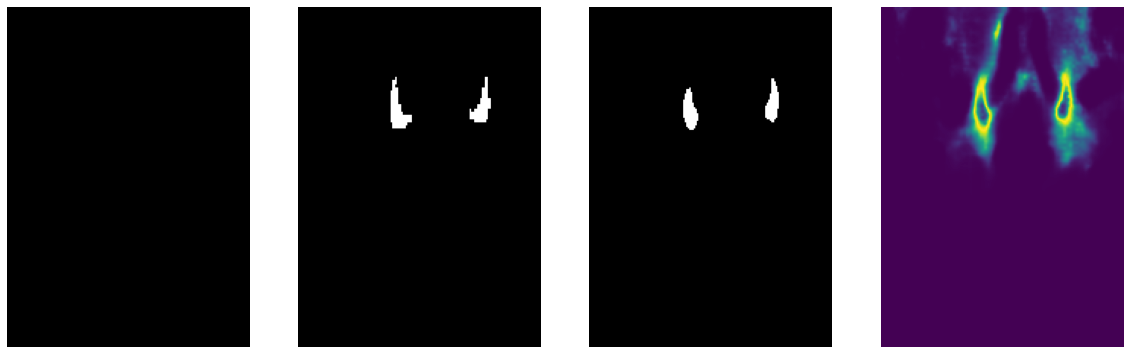

In [50]:
ind = 50
plt.figure(figsize=(20,7))
plt.subplot(1,4,1)
plt.imshow(x1[ind][0,:,:],cmap='gray'); plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(y1[ind], cmap='gray'); plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(torch.nn.functional.softmax(y_hat['logit_mean'].cpu(), dim=1).argmax(dim=1)[ind], cmap='gray'); plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(ent_map[ind]); plt.axis('off')
#print(slice_dice(y_hat['logit_mean'].cpu()[ind], y1[ind]))
plt.show()

### Looking at the 3D dice

In [51]:
# load datasets
# this step is quite slow, all the data is being loaded into memory
# BIG NOTE
# during evaluating the modle, we set is_3d false here to avoid doing the z cropping (which can cause nans)
# and instead we run the whole brain scan through and it gives us a good prediction over all. Nice.
datasets_domains_3d = [MRISegmentation3DDataset(root_dir, domain, transforms=get_transforms(is_3D=False)) for domain in domains]


# split into train, val test datasets
datasets_3d = [train_val_test_split(dataset, validation_proportion, test_proportion, seed) for dataset in datasets_domains_3d]

# concat the train val test datsets
train_dataset_3d = ConcatDataset([ds[0] for ds in datasets_3d])
val_dataset_3d = ConcatDataset([ds[1] for ds in datasets_3d])
test_dataset_3d = ConcatDataset([ds[2] for ds in datasets_3d])

In [52]:
len(train_dataset_3d), len(val_dataset_3d), len(test_dataset_3d)

(177, 49, 24)

In [55]:
values = []
with torch.no_grad():
    model.eval()
    for i, (scan, label) in enumerate(val_dataset_3d):
        flipped = scan.permute(1,0,2,3)
        model.eval()
        pred = model(flipped)
        score = dice(pred['logit_mean'].cpu(), label)
        if not torch.isnan(score):
            values.append(score)
        print(i, score)
mean = torch.mean(torch.Tensor(values))
print("----\nmean: ", mean)

0 tensor(0.6535)
1 tensor(0.6306)
2 tensor(0.6704)
3 tensor(0.7015)
4 tensor(0.7215)
5 tensor(0.6413)
6 tensor(0.5947)
7 tensor(0.7857)
8 tensor(0.5138)
9 tensor(0.8627)
10 tensor(0.6655)
11 tensor(0.5303)
12 tensor(0.7501)
13 tensor(0.4928)
14 tensor(0.6051)
15 tensor(0.7917)
16 tensor(0.7779)
17 tensor(0.7210)
18 tensor(0.7269)
19 tensor(0.9253)
20 tensor(0.8109)
21 tensor(0.7837)
22 tensor(0.5717)
23 tensor(0.7118)
24 tensor(0.7636)
25 tensor(0.8884)
26 tensor(0.7986)
27 tensor(0.8284)
28 tensor(0.3091)
29 tensor(0.7083)
30 tensor(0.6499)
31 tensor(0.5460)
32 tensor(0.4954)
33 tensor(0.7920)
34 tensor(0.7895)
35 tensor(0.7558)
36 tensor(0.5331)
37 tensor(0.8236)
38 tensor(0.6828)
39 tensor(0.7630)
40 tensor(0.7160)
41 tensor(0.4569)
42 tensor(0.5548)
43 tensor(0.6720)
44 tensor(0.5648)
45 tensor(0.6772)
46 tensor(0.6571)
47 tensor(0.6715)
48 tensor(0.8067)
----
mean:  tensor(0.6846)


In [63]:
# now look at best dice
values = []
with torch.no_grad():
    model.eval()
    for i, (scan, label) in enumerate(val_dataset_3d):
        flipped = scan.permute(1,0,2,3)
        model.eval()
        pred = model(flipped)
        samples = fixed_re_parametrization_trick(pred['distribution'], 14)
        scores = []
        for s in samples:
            score = dice(s, label)
            if not torch.isnan(score):
                scores.append(score)
        print(i, scores)
        values.append(scores)
mean = torch.mean(torch.Tensor(values))
print("----\nmean: ", mean)

0 [tensor(0.6503), tensor(0.6581), tensor(0.6493), tensor(0.6688), tensor(0.6517), tensor(0.6507), tensor(0.6378), tensor(0.6532), tensor(0.6441), tensor(0.6359), tensor(0.6485), tensor(0.6539), tensor(0.6636), tensor(0.6650)]
1 [tensor(0.6633), tensor(0.6550), tensor(0.6131), tensor(0.6656), tensor(0.6652), tensor(0.6716), tensor(0.6446), tensor(0.6672), tensor(0.6622), tensor(0.6738), tensor(0.6608), tensor(0.6757), tensor(0.6569), tensor(0.6381)]
2 [tensor(0.6653), tensor(0.6766), tensor(0.6620), tensor(0.6908), tensor(0.6688), tensor(0.6708), tensor(0.6578), tensor(0.6163), tensor(0.6261), tensor(0.6478), tensor(0.6637), tensor(0.6237), tensor(0.6735), tensor(0.6709)]
3 [tensor(0.7553), tensor(0.7571), tensor(0.7326), tensor(0.7658), tensor(0.7670), tensor(0.7653), tensor(0.7606), tensor(0.7550), tensor(0.7527), tensor(0.7478), tensor(0.7459), tensor(0.7462), tensor(0.7579), tensor(0.7605)]
4 [tensor(0.7978), tensor(0.8011), tensor(0.7970), tensor(0.7907), tensor(0.8087), tensor(0.

In [66]:
maxes = torch.Tensor([torch.Tensor(vs).max() for vs in values])

In [68]:
maxes.mean()

tensor(0.7004)

### Looking at WMdamage of a 3D brain

In [69]:
from tqdm import tqdm

In [70]:
true_wmh_damage = []
lhss = []
rhss = []

with torch.no_grad():
    model.eval()
    for i, (x, y) in tqdm(enumerate(train_dataset_3d), position=0, leave=True, ncols=150):
        wmh_voxels = x[0][y==1]
        nawm_voxels = x[0][torch.logical_and(torch.logical_and(y==0, x[1] == 1), x[0] > 0)]
        
        I_wmh = torch.mean(wmh_voxels)
        I_nawm = torch.mean(nawm_voxels)
        
        wmh_volume = wmh_voxels.shape[0]
        nawm_volume = nawm_voxels.shape[0]
        
        lhs = ((I_wmh - I_nawm) / I_nawm)
        rhs = (wmh_volume / (wmh_volume + nawm_volume))
        damage = lhs * rhs
        
        true_wmh_damage.append(damage)
        lhss.append(lhs)
        rhss.append(rhs)
        
        print("I_wmh: ", I_wmh, "I_nawm: ", I_nawm, "wmh volume: ", wmh_volume, "normal volume: ", nawm_volume, lhs, rhs, damage)
        

5it [00:00, 24.01it/s]

I_wmh:  tensor(1.7016) I_nawm:  tensor(0.4402) wmh volume:  59756 normal volume:  351102 tensor(2.8653) 0.1454419775202138 tensor(0.4167)
I_wmh:  tensor(1.0575) I_nawm:  tensor(0.5463) wmh volume:  1757 normal volume:  417849 tensor(0.9357) 0.004187261383297665 tensor(0.0039)
I_wmh:  tensor(1.3936) I_nawm:  tensor(0.5635) wmh volume:  3260 normal volume:  543054 tensor(1.4732) 0.0059672642473010025 tensor(0.0088)
I_wmh:  tensor(1.9016) I_nawm:  tensor(0.4863) wmh volume:  53523 normal volume:  566283 tensor(2.9107) 0.08635443993765791 tensor(0.2513)
I_wmh:  tensor(1.6890) I_nawm:  tensor(0.5731) wmh volume:  19913 normal volume:  718844 tensor(1.9472) 0.02695473613109588 tensor(0.0525)
I_wmh:  tensor(1.3815) I_nawm:  tensor(0.5533) wmh volume:  4063 normal volume:  522400 tensor(1.4968) 0.0077175414036693936 tensor(0.0116)
I_wmh:  tensor(1.6083) I_nawm:  tensor(0.5780) wmh volume:  5449 normal volume:  537108 tensor(1.7823) 0.01004318440274478 tensor(0.0179)
I_wmh:  tensor(1.4610) I_na

14it [00:00, 33.92it/s]

I_wmh:  tensor(1.9268) I_nawm:  tensor(0.4890) wmh volume:  9600 normal volume:  159174 tensor(2.9400) 0.05688079917522841 tensor(0.1672)
I_wmh:  tensor(2.0195) I_nawm:  tensor(0.4952) wmh volume:  50551 normal volume:  568091 tensor(3.0786) 0.08171284846486336 tensor(0.2516)
I_wmh:  tensor(2.0309) I_nawm:  tensor(0.4929) wmh volume:  26841 normal volume:  373363 tensor(3.1206) 0.06706829516946357 tensor(0.2093)
I_wmh:  tensor(0.8031) I_nawm:  tensor(0.5920) wmh volume:  2929 normal volume:  508415 tensor(0.3566) 0.005728042179041898 tensor(0.0020)
I_wmh:  tensor(1.7380) I_nawm:  tensor(0.5689) wmh volume:  7329 normal volume:  315961 tensor(2.0550) 0.0226700485632095 tensor(0.0466)
I_wmh:  tensor(0.) I_nawm:  tensor(nan) wmh volume:  18405 normal volume:  0 tensor(nan) 1.0 tensor(nan)
I_wmh:  tensor(1.3816) I_nawm:  tensor(0.5275) wmh volume:  5200 normal volume:  648195 tensor(1.6192) 0.007958432494892064 tensor(0.0129)
I_wmh:  tensor(1.6764) I_nawm:  tensor(0.5292) wmh volume:  4342

24it [00:00, 40.39it/s]

I_wmh:  tensor(1.9007) I_nawm:  tensor(0.5106) wmh volume:  33361 normal volume:  416997 tensor(2.7226) 0.07407662348620431 tensor(0.2017)
I_wmh:  tensor(1.1916) I_nawm:  tensor(0.5222) wmh volume:  2303 normal volume:  488913 tensor(1.2818) 0.004688365199830624 tensor(0.0060)
I_wmh:  tensor(1.1132) I_nawm:  tensor(0.5227) wmh volume:  3982 normal volume:  624414 tensor(1.1296) 0.00633676853449099 tensor(0.0072)
I_wmh:  tensor(1.4395) I_nawm:  tensor(0.6157) wmh volume:  4788 normal volume:  532598 tensor(1.3382) 0.008909796682459163 tensor(0.0119)
I_wmh:  tensor(1.5172) I_nawm:  tensor(0.6353) wmh volume:  3971 normal volume:  395514 tensor(1.3882) 0.00994029813384733 tensor(0.0138)
I_wmh:  tensor(0.9507) I_nawm:  tensor(0.6146) wmh volume:  1332 normal volume:  392785 tensor(0.5468) 0.003379707041310068 tensor(0.0018)
I_wmh:  tensor(1.6979) I_nawm:  tensor(0.5668) wmh volume:  6288 normal volume:  605099 tensor(1.9953) 0.010284811420589577 tensor(0.0205)
I_wmh:  tensor(1.2358) I_nawm

34it [00:00, 40.78it/s]

I_wmh:  tensor(1.9068) I_nawm:  tensor(0.4809) wmh volume:  42072 normal volume:  361636 tensor(2.9653) 0.10421393680581013 tensor(0.3090)
I_wmh:  tensor(1.4282) I_nawm:  tensor(0.5747) wmh volume:  4004 normal volume:  482526 tensor(1.4851) 0.008229708342753788 tensor(0.0122)
I_wmh:  tensor(1.8844) I_nawm:  tensor(0.5518) wmh volume:  10793 normal volume:  526218 tensor(2.4151) 0.020098284765116544 tensor(0.0485)
I_wmh:  tensor(1.2616) I_nawm:  tensor(0.4651) wmh volume:  2459 normal volume:  501271 tensor(1.7127) 0.004881583387926072 tensor(0.0084)
I_wmh:  tensor(2.0232) I_nawm:  tensor(0.4659) wmh volume:  62500 normal volume:  481249 tensor(3.3428) 0.11494274012457954 tensor(0.3842)
I_wmh:  tensor(1.0024) I_nawm:  tensor(0.5200) wmh volume:  3870 normal volume:  634534 tensor(0.9279) 0.006061992092781373 tensor(0.0056)
I_wmh:  tensor(1.8505) I_nawm:  tensor(0.5425) wmh volume:  20688 normal volume:  602906 tensor(2.4112) 0.03317543145059125 tensor(0.0800)
I_wmh:  tensor(0.8692) I_n

39it [00:01, 37.86it/s]

I_wmh:  tensor(1.6013) I_nawm:  tensor(0.5835) wmh volume:  34338 normal volume:  675908 tensor(1.7444) 0.048346629196081355 tensor(0.0843)
I_wmh:  tensor(1.3220) I_nawm:  tensor(0.5757) wmh volume:  9089 normal volume:  617615 tensor(1.2966) 0.014502859404120605 tensor(0.0188)
I_wmh:  tensor(1.5984) I_nawm:  tensor(0.6467) wmh volume:  5750 normal volume:  350202 tensor(1.4715) 0.016153863442261877 tensor(0.0238)
I_wmh:  tensor(1.4266) I_nawm:  tensor(0.5820) wmh volume:  9715 normal volume:  372123 tensor(1.4512) 0.02544272702035942 tensor(0.0369)
I_wmh:  tensor(1.4367) I_nawm:  tensor(0.6305) wmh volume:  25413 normal volume:  594356 tensor(1.2788) 0.041003986969338574 tensor(0.0524)
I_wmh:  tensor(0.9834) I_nawm:  tensor(0.5198) wmh volume:  3452 normal volume:  583475 tensor(0.8919) 0.005881481001896317 tensor(0.0052)


47it [00:01, 30.93it/s]

I_wmh:  tensor(0.8761) I_nawm:  tensor(0.5261) wmh volume:  844 normal volume:  548267 tensor(0.6651) 0.001537029853708995 tensor(0.0010)
I_wmh:  tensor(1.0691) I_nawm:  tensor(0.5699) wmh volume:  4820 normal volume:  547056 tensor(0.8760) 0.008733846008886053 tensor(0.0077)
I_wmh:  tensor(1.7287) I_nawm:  tensor(0.5331) wmh volume:  21205 normal volume:  492054 tensor(2.2429) 0.04131442410167187 tensor(0.0927)
I_wmh:  tensor(1.5106) I_nawm:  tensor(0.5879) wmh volume:  10316 normal volume:  507558 tensor(1.5693) 0.019919903296940954 tensor(0.0313)
I_wmh:  tensor(1.4778) I_nawm:  tensor(0.6122) wmh volume:  21609 normal volume:  288555 tensor(1.4138) 0.06966959415019151 tensor(0.0985)
I_wmh:  tensor(1.3373) I_nawm:  tensor(0.5857) wmh volume:  4945 normal volume:  495031 tensor(1.2832) 0.009890474742787654 tensor(0.0127)


51it [00:01, 32.61it/s]

I_wmh:  tensor(0.8645) I_nawm:  tensor(0.5642) wmh volume:  2796 normal volume:  754562 tensor(0.5323) 0.0036917811655782337 tensor(0.0020)
I_wmh:  tensor(1.7083) I_nawm:  tensor(0.5335) wmh volume:  39530 normal volume:  543075 tensor(2.2018) 0.06785043039452116 tensor(0.1494)
I_wmh:  tensor(1.4488) I_nawm:  tensor(0.6627) wmh volume:  9456 normal volume:  580507 tensor(1.1863) 0.016028123797594086 tensor(0.0190)
I_wmh:  tensor(1.0911) I_nawm:  tensor(0.5272) wmh volume:  1038 normal volume:  610421 tensor(1.0698) 0.0016975790690790388 tensor(0.0018)
I_wmh:  tensor(1.0773) I_nawm:  tensor(0.5349) wmh volume:  1848 normal volume:  591598 tensor(1.0139) 0.0031140154285309867 tensor(0.0032)
I_wmh:  tensor(1.1222) I_nawm:  tensor(0.5643) wmh volume:  5920 normal volume:  521112 tensor(0.9886) 0.011232714522078356 tensor(0.0111)


59it [00:01, 29.79it/s]

I_wmh:  tensor(1.6873) I_nawm:  tensor(0.6375) wmh volume:  11338 normal volume:  467128 tensor(1.6466) 0.023696563601175422 tensor(0.0390)
I_wmh:  tensor(1.5331) I_nawm:  tensor(0.5703) wmh volume:  2985 normal volume:  577673 tensor(1.6881) 0.005140719666309601 tensor(0.0087)
I_wmh:  tensor(1.8204) I_nawm:  tensor(0.6242) wmh volume:  8302 normal volume:  507767 tensor(1.9162) 0.016086996118736062 tensor(0.0308)
I_wmh:  tensor(1.6980) I_nawm:  tensor(0.5746) wmh volume:  22877 normal volume:  535018 tensor(1.9553) 0.04100592405380941 tensor(0.0802)
I_wmh:  tensor(1.8299) I_nawm:  tensor(0.6770) wmh volume:  9554 normal volume:  467826 tensor(1.7029) 0.02001340651053668 tensor(0.0341)


63it [00:01, 26.17it/s]

I_wmh:  tensor(1.3786) I_nawm:  tensor(0.4829) wmh volume:  10136 normal volume:  333689 tensor(1.8551) 0.029480113429797134 tensor(0.0547)
I_wmh:  tensor(1.1801) I_nawm:  tensor(0.6064) wmh volume:  2542 normal volume:  605313 tensor(0.9460) 0.004181918385141193 tensor(0.0040)
I_wmh:  tensor(1.6004) I_nawm:  tensor(0.6251) wmh volume:  3045 normal volume:  697987 tensor(1.5601) 0.0043435962980291915 tensor(0.0068)
I_wmh:  tensor(1.6705) I_nawm:  tensor(0.6340) wmh volume:  7212 normal volume:  470508 tensor(1.6348) 0.01509670936950515 tensor(0.0247)
I_wmh:  tensor(2.1221) I_nawm:  tensor(0.6081) wmh volume:  10690 normal volume:  281506 tensor(2.4896) 0.03658503196484551 tensor(0.0911)


69it [00:02, 22.74it/s]

I_wmh:  tensor(1.7835) I_nawm:  tensor(0.6021) wmh volume:  11964 normal volume:  450755 tensor(1.9620) 0.02585586500662389 tensor(0.0507)
I_wmh:  tensor(1.1316) I_nawm:  tensor(0.6944) wmh volume:  1494 normal volume:  792205 tensor(0.6297) 0.0018823256675389536 tensor(0.0012)
I_wmh:  tensor(1.9938) I_nawm:  tensor(0.3565) wmh volume:  65222 normal volume:  280778 tensor(4.5929) 0.1885028901734104 tensor(0.8658)
I_wmh:  tensor(0.) I_nawm:  tensor(nan) wmh volume:  49863 normal volume:  0 tensor(nan) 1.0 tensor(nan)
I_wmh:  tensor(1.6523) I_nawm:  tensor(0.5882) wmh volume:  7221 normal volume:  341926 tensor(1.8089) 0.02068183315337093 tensor(0.0374)


72it [00:02, 22.55it/s]

I_wmh:  tensor(1.6153) I_nawm:  tensor(0.6836) wmh volume:  2513 normal volume:  470204 tensor(1.3630) 0.005316077060905362 tensor(0.0072)
I_wmh:  tensor(1.4017) I_nawm:  tensor(0.5339) wmh volume:  5558 normal volume:  583035 tensor(1.6254) 0.009442857798172931 tensor(0.0153)
I_wmh:  tensor(1.6579) I_nawm:  tensor(0.5885) wmh volume:  3135 normal volume:  512522 tensor(1.8169) 0.006079622694930933 tensor(0.0110)
I_wmh:  tensor(1.2726) I_nawm:  tensor(0.6564) wmh volume:  1323 normal volume:  549973 tensor(0.9386) 0.002399799744601811 tensor(0.0023)
I_wmh:  tensor(1.2426) I_nawm:  tensor(0.5382) wmh volume:  2770 normal volume:  462995 tensor(1.3087) 0.00594720513563707 tensor(0.0078)


79it [00:02, 24.36it/s]

I_wmh:  tensor(1.5592) I_nawm:  tensor(0.6557) wmh volume:  8378 normal volume:  562751 tensor(1.3779) 0.014669190323026847 tensor(0.0202)
I_wmh:  tensor(1.6603) I_nawm:  tensor(0.5988) wmh volume:  10995 normal volume:  677082 tensor(1.7726) 0.015979316268382754 tensor(0.0283)
I_wmh:  tensor(1.4732) I_nawm:  tensor(0.5893) wmh volume:  2630 normal volume:  594448 tensor(1.4998) 0.004404784634503365 tensor(0.0066)
I_wmh:  tensor(1.6896) I_nawm:  tensor(0.6052) wmh volume:  6363 normal volume:  630872 tensor(1.7916) 0.009985327234065925 tensor(0.0179)
I_wmh:  tensor(1.0778) I_nawm:  tensor(0.6688) wmh volume:  3026 normal volume:  545031 tensor(0.6114) 0.00552132351197047 tensor(0.0034)
I_wmh:  tensor(1.3839) I_nawm:  tensor(0.6571) wmh volume:  2476 normal volume:  595419 tensor(1.1062) 0.004141195360389366 tensor(0.0046)


85it [00:02, 22.91it/s]

I_wmh:  tensor(1.7389) I_nawm:  tensor(0.5518) wmh volume:  53124 normal volume:  409161 tensor(2.1512) 0.11491612317077128 tensor(0.2472)
I_wmh:  tensor(1.9592) I_nawm:  tensor(0.5373) wmh volume:  39829 normal volume:  439224 tensor(2.6462) 0.08314111382247893 tensor(0.2200)
I_wmh:  tensor(1.7757) I_nawm:  tensor(0.5495) wmh volume:  11959 normal volume:  576449 tensor(2.2317) 0.020324332775896996 tensor(0.0454)
I_wmh:  tensor(1.7050) I_nawm:  tensor(0.6375) wmh volume:  9053 normal volume:  539197 tensor(1.6747) 0.016512539899680802 tensor(0.0277)
I_wmh:  tensor(1.1742) I_nawm:  tensor(0.7178) wmh volume:  1394 normal volume:  413138 tensor(0.6357) 0.0033628284426775257 tensor(0.0021)
I_wmh:  tensor(2.0099) I_nawm:  tensor(0.5084) wmh volume:  41731 normal volume:  529075 tensor(2.9531) 0.07310890214889122 tensor(0.2159)


92it [00:03, 24.90it/s]

I_wmh:  tensor(1.0080) I_nawm:  tensor(0.5722) wmh volume:  1064 normal volume:  643436 tensor(0.7617) 0.0016508921644685802 tensor(0.0013)
I_wmh:  tensor(1.8195) I_nawm:  tensor(0.5740) wmh volume:  16664 normal volume:  561364 tensor(2.1699) 0.02882905326385573 tensor(0.0626)
I_wmh:  tensor(0.9313) I_nawm:  tensor(0.6230) wmh volume:  1809 normal volume:  696590 tensor(0.4950) 0.002590209894344064 tensor(0.0013)
I_wmh:  tensor(1.6045) I_nawm:  tensor(0.6065) wmh volume:  22634 normal volume:  651413 tensor(1.6456) 0.033579260793386814 tensor(0.0553)
I_wmh:  tensor(1.4146) I_nawm:  tensor(0.5799) wmh volume:  1129 normal volume:  401014 tensor(1.4394) 0.0028074590382028285 tensor(0.0040)
I_wmh:  tensor(1.7600) I_nawm:  tensor(0.6774) wmh volume:  9300 normal volume:  424528 tensor(1.5981) 0.021437067224798767 tensor(0.0343)


95it [00:03, 24.37it/s]

I_wmh:  tensor(1.4125) I_nawm:  tensor(0.5764) wmh volume:  6588 normal volume:  676958 tensor(1.4504) 0.00963797608354083 tensor(0.0140)
I_wmh:  tensor(1.9656) I_nawm:  tensor(0.6311) wmh volume:  44163 normal volume:  488898 tensor(2.1144) 0.08284792922385993 tensor(0.1752)
I_wmh:  tensor(0.9476) I_nawm:  tensor(0.6892) wmh volume:  1263 normal volume:  223426 tensor(0.3750) 0.0056211029467397155 tensor(0.0021)
I_wmh:  tensor(0.) I_nawm:  tensor(nan) wmh volume:  15632 normal volume:  0 tensor(nan) 1.0 tensor(nan)
I_wmh:  tensor(1.8044) I_nawm:  tensor(0.7204) wmh volume:  5933 normal volume:  389809 tensor(1.5047) 0.014992090806636648 tensor(0.0226)


102it [00:03, 27.95it/s]

I_wmh:  tensor(1.9456) I_nawm:  tensor(0.4592) wmh volume:  55419 normal volume:  272350 tensor(3.2365) 0.16907944314440962 tensor(0.5472)
I_wmh:  tensor(1.8938) I_nawm:  tensor(0.6530) wmh volume:  2772 normal volume:  484898 tensor(1.9000) 0.005684171673467714 tensor(0.0108)
I_wmh:  tensor(1.3382) I_nawm:  tensor(0.5481) wmh volume:  5434 normal volume:  448615 tensor(1.4414) 0.011967871309043738 tensor(0.0173)
I_wmh:  tensor(1.7363) I_nawm:  tensor(0.5546) wmh volume:  46803 normal volume:  499286 tensor(2.1308) 0.08570580985883254 tensor(0.1826)
I_wmh:  tensor(1.5823) I_nawm:  tensor(0.7138) wmh volume:  4672 normal volume:  438801 tensor(1.2167) 0.010535026935123447 tensor(0.0128)
I_wmh:  tensor(1.5170) I_nawm:  tensor(0.5696) wmh volume:  13326 normal volume:  665140 tensor(1.6633) 0.019641367437719798 tensor(0.0327)
I_wmh:  tensor(1.5444) I_nawm:  tensor(0.5430) wmh volume:  9998 normal volume:  487881 tensor(1.8441) 0.020081184384157597 tensor(0.0370)
I_wmh:  tensor(1.6852) I_n

110it [00:03, 32.88it/s]

I_wmh:  tensor(2.1162) I_nawm:  tensor(0.4955) wmh volume:  29546 normal volume:  570321 tensor(3.2706) 0.04925425135905125 tensor(0.1611)
I_wmh:  tensor(1.4060) I_nawm:  tensor(0.5943) wmh volume:  63330 normal volume:  441432 tensor(1.3658) 0.1254650706669678 tensor(0.1714)
I_wmh:  tensor(2.1777) I_nawm:  tensor(0.4828) wmh volume:  37421 normal volume:  541062 tensor(3.5103) 0.06468815851114035 tensor(0.2271)
I_wmh:  tensor(1.6940) I_nawm:  tensor(0.4717) wmh volume:  20048 normal volume:  518514 tensor(2.5913) 0.037225054868334564 tensor(0.0965)
I_wmh:  tensor(1.3481) I_nawm:  tensor(0.6557) wmh volume:  7272 normal volume:  501153 tensor(1.0559) 0.014302994541967842 tensor(0.0151)
I_wmh:  tensor(1.5884) I_nawm:  tensor(0.5229) wmh volume:  19887 normal volume:  538521 tensor(2.0375) 0.03561374478875661 tensor(0.0726)
I_wmh:  tensor(1.9813) I_nawm:  tensor(0.6944) wmh volume:  19545 normal volume:  419070 tensor(1.8533) 0.04456071953763551 tensor(0.0826)
I_wmh:  tensor(1.8065) I_na

118it [00:04, 33.03it/s]

I_wmh:  tensor(2.0091) I_nawm:  tensor(0.6124) wmh volume:  3985 normal volume:  247620 tensor(2.2807) 0.015838317998449952 tensor(0.0361)
I_wmh:  tensor(1.6058) I_nawm:  tensor(0.5700) wmh volume:  2026 normal volume:  636717 tensor(1.8174) 0.003171854720912793 tensor(0.0058)
I_wmh:  tensor(1.4734) I_nawm:  tensor(0.5804) wmh volume:  5439 normal volume:  528984 tensor(1.5387) 0.010177331439702259 tensor(0.0157)
I_wmh:  tensor(1.8018) I_nawm:  tensor(0.5313) wmh volume:  15366 normal volume:  562180 tensor(2.3913) 0.02660567296804064 tensor(0.0636)
I_wmh:  tensor(2.0928) I_nawm:  tensor(0.4513) wmh volume:  31945 normal volume:  544195 tensor(3.6376) 0.05544659284201756 tensor(0.2017)
I_wmh:  tensor(1.9926) I_nawm:  tensor(0.5886) wmh volume:  26840 normal volume:  281609 tensor(2.3855) 0.08701600588752112 tensor(0.2076)
I_wmh:  tensor(1.2061) I_nawm:  tensor(0.5255) wmh volume:  155 normal volume:  563646 tensor(1.2952) 0.0002749196968433898 tensor(0.0004)


126it [00:04, 34.20it/s]

I_wmh:  tensor(2.1803) I_nawm:  tensor(0.6067) wmh volume:  16374 normal volume:  606701 tensor(2.5937) 0.02627934036833447 tensor(0.0682)
I_wmh:  tensor(1.7972) I_nawm:  tensor(0.5776) wmh volume:  1194 normal volume:  610062 tensor(2.1117) 0.0019533550590914443 tensor(0.0041)
I_wmh:  tensor(2.1370) I_nawm:  tensor(0.5183) wmh volume:  44189 normal volume:  479212 tensor(3.1233) 0.08442666330404412 tensor(0.2637)
I_wmh:  tensor(1.0448) I_nawm:  tensor(0.5575) wmh volume:  12488 normal volume:  584860 tensor(0.8742) 0.020905736689500926 tensor(0.0183)
I_wmh:  tensor(1.7149) I_nawm:  tensor(0.5578) wmh volume:  37660 normal volume:  535311 tensor(2.0741) 0.06572758481668357 tensor(0.1363)
I_wmh:  tensor(1.4461) I_nawm:  tensor(0.5555) wmh volume:  11297 normal volume:  403267 tensor(1.6032) 0.027250315994635326 tensor(0.0437)
I_wmh:  tensor(1.5640) I_nawm:  tensor(0.7146) wmh volume:  2328 normal volume:  468431 tensor(1.1887) 0.004945205508551084 tensor(0.0059)


134it [00:04, 30.59it/s]

I_wmh:  tensor(1.5956) I_nawm:  tensor(0.6110) wmh volume:  1056 normal volume:  328865 tensor(1.6114) 0.00320076624404024 tensor(0.0052)
I_wmh:  tensor(1.1892) I_nawm:  tensor(0.5985) wmh volume:  3573 normal volume:  717908 tensor(0.9871) 0.004952313366533561 tensor(0.0049)
I_wmh:  tensor(1.7689) I_nawm:  tensor(0.5064) wmh volume:  36283 normal volume:  487513 tensor(2.4932) 0.06926933386280155 tensor(0.1727)
I_wmh:  tensor(1.2042) I_nawm:  tensor(0.6419) wmh volume:  2867 normal volume:  588659 tensor(0.8761) 0.004846786109148203 tensor(0.0042)
I_wmh:  tensor(2.0162) I_nawm:  tensor(0.6014) wmh volume:  5549 normal volume:  601751 tensor(2.3523) 0.009137164498600362 tensor(0.0215)
I_wmh:  tensor(1.5829) I_nawm:  tensor(0.5504) wmh volume:  653 normal volume:  357136 tensor(1.8758) 0.001825098032639349 tensor(0.0034)
I_wmh:  tensor(1.9187) I_nawm:  tensor(0.4713) wmh volume:  45506 normal volume:  512222 tensor(3.0714) 0.08159174364564806 tensor(0.2506)


138it [00:04, 30.68it/s]

I_wmh:  tensor(1.9200) I_nawm:  tensor(0.5890) wmh volume:  13969 normal volume:  383550 tensor(2.2600) 0.03514045869505609 tensor(0.0794)
I_wmh:  tensor(1.7631) I_nawm:  tensor(0.5582) wmh volume:  15903 normal volume:  517736 tensor(2.1586) 0.029801045275926235 tensor(0.0643)
I_wmh:  tensor(1.4621) I_nawm:  tensor(0.5424) wmh volume:  2759 normal volume:  518758 tensor(1.6958) 0.0052903356937549495 tensor(0.0090)
I_wmh:  tensor(1.7935) I_nawm:  tensor(0.6383) wmh volume:  23165 normal volume:  288058 tensor(1.8099) 0.07443215957689503 tensor(0.1347)
I_wmh:  tensor(0.) I_nawm:  tensor(nan) wmh volume:  5085 normal volume:  0 tensor(nan) 1.0 tensor(nan)
I_wmh:  tensor(2.0029) I_nawm:  tensor(0.5246) wmh volume:  36182 normal volume:  633496 tensor(2.8176) 0.054028951227306256 tensor(0.1522)
I_wmh:  tensor(1.4400) I_nawm:  tensor(0.4977) wmh volume:  802 normal volume:  264490 tensor(1.8936) 0.00302308399800974 tensor(0.0057)


146it [00:04, 31.71it/s]

I_wmh:  tensor(1.9028) I_nawm:  tensor(0.5550) wmh volume:  13219 normal volume:  636071 tensor(2.4288) 0.020359161545688367 tensor(0.0494)
I_wmh:  tensor(1.0724) I_nawm:  tensor(0.5373) wmh volume:  3263 normal volume:  625258 tensor(0.9959) 0.005191552867764164 tensor(0.0052)
I_wmh:  tensor(1.5394) I_nawm:  tensor(0.5973) wmh volume:  9480 normal volume:  514053 tensor(1.5774) 0.01810774105930285 tensor(0.0286)
I_wmh:  tensor(1.3545) I_nawm:  tensor(0.6050) wmh volume:  1492 normal volume:  473362 tensor(1.2389) 0.0031420183888100344 tensor(0.0039)
I_wmh:  tensor(1.7856) I_nawm:  tensor(0.5580) wmh volume:  2668 normal volume:  539412 tensor(2.1999) 0.004921782762691854 tensor(0.0108)
I_wmh:  tensor(1.9542) I_nawm:  tensor(0.4893) wmh volume:  26711 normal volume:  585236 tensor(2.9942) 0.043649204914804715 tensor(0.1307)
I_wmh:  tensor(1.5300) I_nawm:  tensor(0.6120) wmh volume:  13517 normal volume:  576445 tensor(1.4998) 0.02291164515680671 tensor(0.0344)
I_wmh:  tensor(1.0857) I_

154it [00:05, 33.67it/s]

I_wmh:  tensor(1.6820) I_nawm:  tensor(0.5570) wmh volume:  11964 normal volume:  732419 tensor(2.0199) 0.016072371346470837 tensor(0.0325)
I_wmh:  tensor(1.0596) I_nawm:  tensor(0.5823) wmh volume:  1294 normal volume:  472493 tensor(0.8196) 0.0027311851106087757 tensor(0.0022)
I_wmh:  tensor(2.0835) I_nawm:  tensor(0.6712) wmh volume:  13771 normal volume:  447874 tensor(2.1044) 0.02983028084350529 tensor(0.0628)
I_wmh:  tensor(1.4511) I_nawm:  tensor(0.5817) wmh volume:  3298 normal volume:  635092 tensor(1.4945) 0.005166121023198985 tensor(0.0077)
I_wmh:  tensor(1.7425) I_nawm:  tensor(0.6991) wmh volume:  23330 normal volume:  442567 tensor(1.4927) 0.050075445860351106 tensor(0.0747)
I_wmh:  tensor(1.9979) I_nawm:  tensor(0.6211) wmh volume:  25702 normal volume:  513334 tensor(2.2169) 0.04768141645455962 tensor(0.1057)
I_wmh:  tensor(1.4039) I_nawm:  tensor(0.4974) wmh volume:  5896 normal volume:  487747 tensor(1.8224) 0.011943854161813294 tensor(0.0218)


162it [00:05, 32.42it/s]

I_wmh:  tensor(1.9496) I_nawm:  tensor(0.5942) wmh volume:  12994 normal volume:  600930 tensor(2.2809) 0.02116548628168959 tensor(0.0483)
I_wmh:  tensor(1.8326) I_nawm:  tensor(0.4726) wmh volume:  30193 normal volume:  628869 tensor(2.8780) 0.045812078378058514 tensor(0.1318)
I_wmh:  tensor(1.2259) I_nawm:  tensor(0.5573) wmh volume:  1442 normal volume:  733680 tensor(1.1997) 0.001961579166451283 tensor(0.0024)
I_wmh:  tensor(1.9924) I_nawm:  tensor(0.5623) wmh volume:  4029 normal volume:  716305 tensor(2.5433) 0.0055932386920511876 tensor(0.0142)
I_wmh:  tensor(1.2590) I_nawm:  tensor(0.5247) wmh volume:  11999 normal volume:  748016 tensor(1.3993) 0.015787846292507384 tensor(0.0221)
I_wmh:  tensor(1.5365) I_nawm:  tensor(0.7343) wmh volume:  24816 normal volume:  316550 tensor(1.0925) 0.07269616774957084 tensor(0.0794)
I_wmh:  tensor(1.6910) I_nawm:  tensor(0.5431) wmh volume:  5251 normal volume:  625366 tensor(2.1139) 0.008326765691378444 tensor(0.0176)


170it [00:05, 32.50it/s]

I_wmh:  tensor(1.4266) I_nawm:  tensor(0.5658) wmh volume:  252 normal volume:  596441 tensor(1.5215) 0.00042232772967003133 tensor(0.0006)
I_wmh:  tensor(2.0538) I_nawm:  tensor(0.5187) wmh volume:  67380 normal volume:  537799 tensor(2.9598) 0.11133895921702505 tensor(0.3295)
I_wmh:  tensor(1.5456) I_nawm:  tensor(0.5774) wmh volume:  3155 normal volume:  556761 tensor(1.6766) 0.005634773787496696 tensor(0.0094)
I_wmh:  tensor(2.2028) I_nawm:  tensor(0.5317) wmh volume:  40058 normal volume:  547775 tensor(3.1432) 0.06814520450536121 tensor(0.2142)
I_wmh:  tensor(1.9159) I_nawm:  tensor(0.6064) wmh volume:  18739 normal volume:  437924 tensor(2.1595) 0.04103463604452298 tensor(0.0886)
I_wmh:  tensor(1.6801) I_nawm:  tensor(0.5800) wmh volume:  32606 normal volume:  356735 tensor(1.8966) 0.08374663855078196 tensor(0.1588)
I_wmh:  tensor(1.6576) I_nawm:  tensor(0.5480) wmh volume:  11709 normal volume:  638013 tensor(2.0246) 0.01802155383379353 tensor(0.0365)


177it [00:05, 30.09it/s]

I_wmh:  tensor(0.9292) I_nawm:  tensor(0.6007) wmh volume:  1156 normal volume:  360819 tensor(0.5469) 0.003193590717590994 tensor(0.0017)
I_wmh:  tensor(1.6235) I_nawm:  tensor(0.6162) wmh volume:  7120 normal volume:  712199 tensor(1.6347) 0.009898250984611834 tensor(0.0162)
I_wmh:  tensor(1.4404) I_nawm:  tensor(0.6168) wmh volume:  18478 normal volume:  572501 tensor(1.3352) 0.031266762439951336 tensor(0.0417)
I_wmh:  tensor(1.1573) I_nawm:  tensor(0.5981) wmh volume:  7996 normal volume:  702050 tensor(0.9348) 0.011261242229376689 tensor(0.0105)
I_wmh:  tensor(2.3304) I_nawm:  tensor(0.5118) wmh volume:  12153 normal volume:  343478 tensor(3.5535) 0.03417306140353344 tensor(0.1214)
I_wmh:  tensor(1.4590) I_nawm:  tensor(0.6147) wmh volume:  19154 normal volume:  552715 tensor(1.3735) 0.03349368474248473 tensor(0.0460)
I_wmh:  tensor(1.4749) I_nawm:  tensor(0.5923) wmh volume:  6143 normal volume:  432534 tensor(1.4901) 0.014003469523134334 tensor(0.0209)


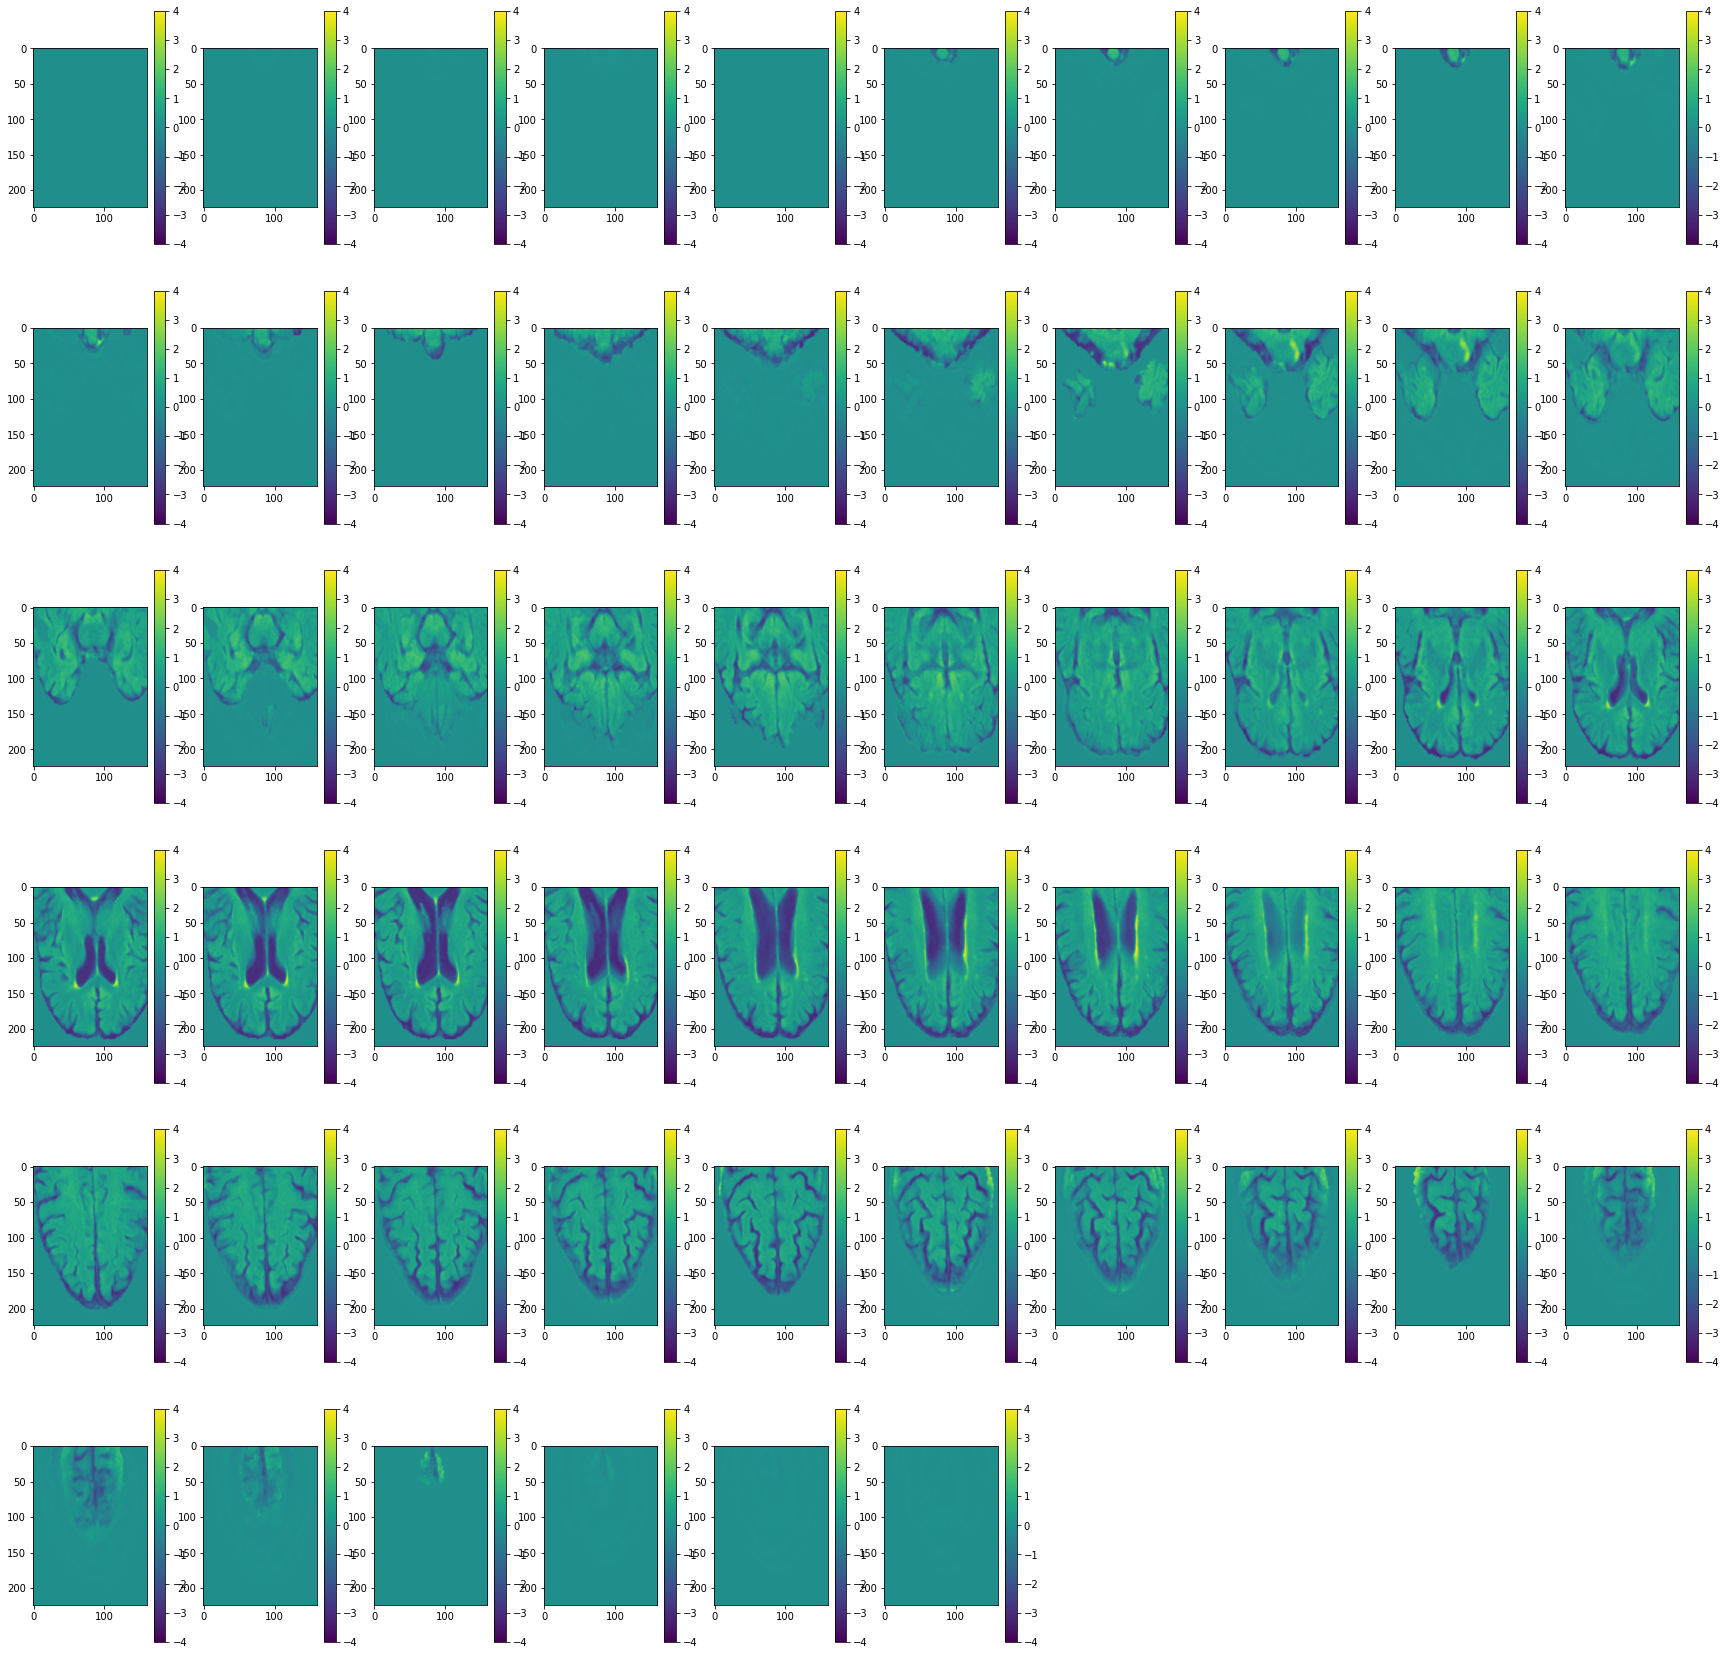

In [58]:
plt.figure(figsize=(30, 30))
for i in range(x.shape[1]):
    plt.subplot(6, 10, i+1)
    plt.imshow(x[0,i], vmin=-4, vmax=4)
    plt.colorbar()

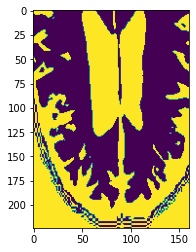

In [59]:
plt.imshow(x[0,35] < 0)

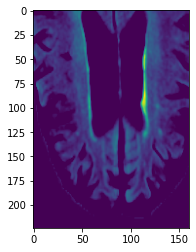

In [60]:
plt.imshow(x[0,35]* (x[0,35] > 0))

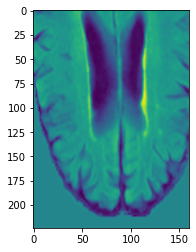

In [61]:
plt.imshow(x[0,35])

### Histogram Analysis

### Quality control prediction in 3D